In [2]:
import pandas as pd
import numpy as np

In [3]:
Emotions = pd.read_csv('/kaggle/input/feature-extract-7emo/emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,Emotions
0,0.036576,0.595285,0.518214,0.467623,0.385958,0.406441,0.428003,0.440104,0.408092,0.355243,...,6.810345e-06,9.494143e-07,1.276122e-07,5.920768e-08,6.259482e-08,6.776799e-08,9.807201e-08,7.782995e-08,3.130733e-08,happy
1,0.129991,0.673687,0.613982,0.580276,0.509139,0.507287,0.473928,0.465629,0.452810,0.439725,...,3.197438e-02,3.272778e-02,3.342170e-02,3.258536e-02,3.363657e-02,3.208363e-02,3.132801e-02,3.186873e-02,3.222414e-02,happy
2,0.042853,0.534393,0.579030,0.523467,0.491737,0.396542,0.397118,0.427628,0.458932,0.404576,...,6.385361e-06,2.748472e-06,4.582715e-07,6.079417e-08,1.479520e-08,1.094685e-08,1.248435e-08,7.627145e-09,1.075299e-09,happy
3,0.047286,0.534577,0.532759,0.547124,0.471091,0.469727,0.530667,0.520320,0.515186,0.549633,...,3.483586e-08,1.314616e-08,7.895075e-09,7.103722e-09,7.353459e-09,6.959937e-09,6.308861e-09,3.876357e-09,4.155905e-10,fear
4,0.119217,0.638274,0.655934,0.668280,0.649310,0.614610,0.629233,0.595497,0.571707,0.587855,...,9.038013e-05,9.201362e-05,8.578269e-05,9.291335e-05,8.828320e-05,9.429989e-05,8.948358e-05,9.301379e-05,9.269559e-05,fear


In [4]:
#taking all rows and all cols without last col for X which include features
#taking last col for Y, which include the emotions


X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [5]:
# As this is a multiclass classification problem onehotencoding our Y
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()


In [6]:
(Y.shape, X.shape)

((36486, 7), (36486, 162))

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 7), (9122, 162), (9122, 7))

In [8]:
#reshape for lstm
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [9]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 7), (9122, 162), (9122, 7))

In [10]:
import keras
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [11]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,mode='auto')
es=EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')

In [12]:
#Build the model

# define model
model000 = Sequential()
model000.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X.shape[1], 1)))
model000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model000.add(BatchNormalization())
model000.add(Dropout(0.3))

          
model000.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model000.add(BatchNormalization())
model000.add(Dropout(0.3))

model000.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model000.add(BatchNormalization())
model000.add(Dropout(0.3))
          
model000.add(LSTM(128, return_sequences=True)) 
model000.add(LSTM(128, return_sequences=True)) 
model000.add(Dropout(0.3))
model000.add(LSTM(128))
model000.add(Dropout(0.3))

model000.add(Dense(128, activation='relu'))
#model000.add(Dropout(0.3))

model000.add(Dense(64, activation='relu'))
#model000.add(Dropout(0.3))

model000.add(Dense(32, activation='relu'))
#model000.add(Dropout(0.3))

model000.add(Dense(7, activation='softmax'))



model000.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 1024)         6144      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 1024)         0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 81, 1024)         4096      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 81, 1024)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 512)           2621952   
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 41, 512)          0

In [13]:
model000.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
hist1=model000.fit(x_train, y_train, batch_size=64, epochs=20, validation_data=(x_test, y_test))

Epoch 1/20
428/428 [==============================] - 20s 46ms/step - loss: 1.3517 - accuracy: 0.4659 - val_loss: 1.3943 - val_accuracy: 0.4383
Epoch 2/20
428/428 [==============================] - 19s 45ms/step - loss: 1.2465 - accuracy: 0.5063 - val_loss: 1.5327 - val_accuracy: 0.3819
Epoch 3/20
428/428 [==============================] - 20s 47ms/step - loss: 1.1874 - accuracy: 0.5305 - val_loss: 1.2153 - val_accuracy: 0.5247
Epoch 4/20
428/428 [==============================] - 19s 45ms/step - loss: 1.1581 - accuracy: 0.5432 - val_loss: 1.1311 - val_accuracy: 0.5520
Epoch 5/20
428/428 [==============================] - 20s 47ms/step - loss: 1.1102 - accuracy: 0.5627 - val_loss: 1.2298 - val_accuracy: 0.4873
Epoch 6/20
428/428 [==============================] - 20s 47ms/step - loss: 1.0980 - accuracy: 0.5688 - val_loss: 1.1795 - val_accuracy: 0.5480
Epoch 7/20
428/428 [==============================] - 19s 45ms/step - loss: 1.0695 - accuracy: 0.5797 - val_loss: 1.1472 - val_accuracy:

In [17]:
from matplotlib import pyplot as plt

286/286 [==============================] - 3s 9ms/step - loss: 0.9570 - accuracy: 0.6324
Accuracy of our model on test data :  63.24270963668823 %


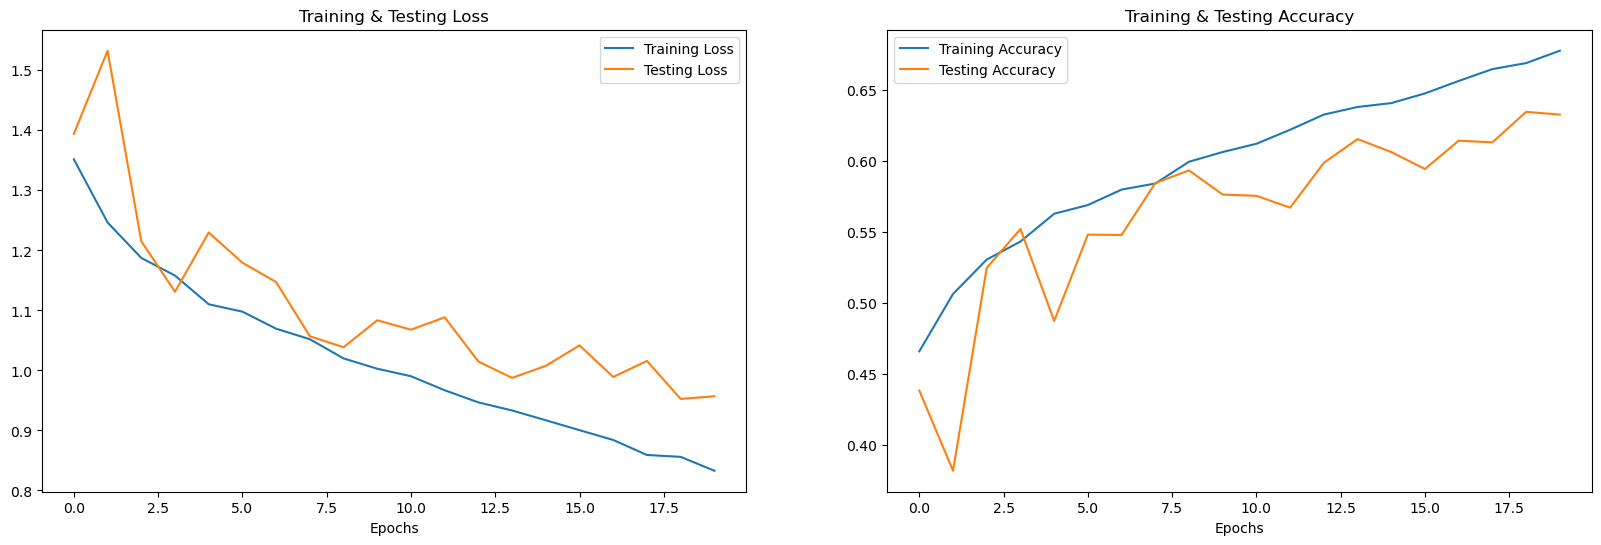

In [19]:
print("Accuracy of our model on test data : " , model000.evaluate(x_test,y_test)[1]*100 , "%")
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = hist1.history['accuracy']
train_loss = hist1.history['loss']
test_acc = hist1.history['val_accuracy']
test_loss = hist1.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [20]:
# predicting on test data.
pred_test00 = model000.predict(x_test)
y_pred00 = encoder.inverse_transform(pred_test00)
y_test00 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred00.flatten()
df0['Actual Labels'] = y_test00.flatten()

df0.head(10)

286/286 [==============================] - 3s 8ms/step


,Predicted Labels,Actual Labels
0,disgust,disgust
1,neutral,disgust
2,neutral,sad
3,disgust,disgust
4,sad,fear
5,disgust,disgust
6,sad,surprise
7,disgust,sad
8,sad,sad
9,angry,angry


In [21]:
# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from tensorflow.keras.models import Sequential, model_from_json
model_json = model000.to_json()
with open("cnnlstmmodel001.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model000.save_weights("cnnlstmmodel001.h5")
print("Saved model to disk") 

Saved model to disk


In [22]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('/kaggle/working/cnnlstmmodel001.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new modela
loaded_model.load_weights("/kaggle/working/cnnlstmmodel001.h5")
print("Loaded model from disk")

Loaded model from disk


In [24]:
loaded_model.compile(optimizer=SGD(lr=0.001, momentum=0.8), loss='categorical_crossentropy', metrics=['accuracy'])
score = loaded_model.evaluate(x_test,y_test)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

286/286 [==============================] - 5s 9ms/step - loss: 0.9570 - accuracy: 0.6324
accuracy: 63.24%


In [14]:
import joblib

#saving scaler
joblib.dump(scaler, 'scaler.joblib')

#loading our scaler

scaler = joblib.load('scaler.joblib')

#saving our encoder

joblib.dump(encoder, 'encoder.joblib')

#loading our encoder

encoder= joblib.load('encoder.joblib')

## Run

In [1]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

import joblib

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
import tensorflow as tf 
print ("Done")

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Done


In [39]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('/kaggle/input/ser-model/cnnlstmmodel001.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new modela
loaded_model.load_weights("/kaggle/input/ser-model/cnnlstmmodel001.h5")
print("Loaded model from disk")

Loaded model from disk


In [41]:
#loading our scaler
scaler = joblib.load('/kaggle/input/ser-model/scaler.joblib')

#loading our encoder
encoder= joblib.load('/kaggle/input/ser-model/encoder.joblib')
print('load scaler encoder done')

load scaler encoder done


In [42]:
def extract_features(data, sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

In [43]:
def get_predict_feat(path):
    d, sample_rate= librosa.load(path, offset=0.6)
    res=extract_features(d, sample_rate)
    result=np.array(res)
    result=np.reshape(result,newshape=(1,162))
    i_result = scaler.transform(result)
    final_result=np.expand_dims(i_result, axis=2)

    return final_result

In [44]:
def prediction(path1):
    res=get_predict_feat(path1)
    predictions=loaded_model.predict(res)
    y_pred = encoder.inverse_transform(predictions)
    print(predictions.max())
    print(y_pred[0][0])    

In [45]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-01-01-02.wav")

1/1 [==============================] - 9s 9s/step
0.57864034
neutral


In [49]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-04-02-01-01-01.wav")

1/1 [==============================] - 0s 47ms/step
0.34144223
sad


In [43]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-05-01-02-02-01.wav")

1/1 [==============================] - 0s 46ms/step
0.57477295
angry


In [44]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_21/03-01-04-02-02-02-21.wav")

1/1 [==============================] - 0s 50ms/step
0.34394222
surprise


In [45]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-06-01-02-02-02.wav")

1/1 [==============================] - 0s 47ms/step
0.8496919
fear
